# Lista 6

## Uczenie maszynowe i sztuczna inteligencja

## Wstęp
**Na tej liście przejdziemy do wykorzystywania rekurencyjnych sieci neuronowych. Zadania sprowadzają się do analizy istniejącego kodu oraz uzupełnienia implementacji oraz przeprowadzenia dodatkowych eksperymentów.**

# Zadanie 1 (15pt)


W tym zadaniu przeanalizujemy różne metody uczenia się na podstawie danych sekwencyjnych.

Powtarzającym się przykładem będzie szkolenie sieci neuronowych w zakresie modelowania języka, czyli przewidywania kolejnego tokenu w zdaniu. W kontekście przetwarzania języka naturalnego tokenem może być znak lub słowo, należy jednak pamiętać, że wprowadzone tutaj koncepcje odnoszą się do wszelkiego rodzaju danych sekwencyjnych, takich jak np.: sygnały audio lub filmy

Aby naprawdę zrozumieć, co dzieje się w rekurencyjnej sieci neuronowej (RNN), znaczną część tego zadania przeprowadzimy w NumPy, a nie w PyTorch lub Kerasie. Zaczynamy od prostego problemu, zbudujemy RNN za pomocą NumPy, trenujemy i przekonamy się, że to naprawdę działa. Gdy będziemy już przekonani, przystępujemy do budowania i uczenia komórki pamięci długoterminowej (LSTM). Celem tego zadania jest po prostu zapewnienie głębszego zrozumienia uczenia RNN. Gdy zrozumiesz wewnętrzne działanie RNN, przejdziemy do implementacji PyTorch, której będzie można używać w pozostałej części listy.

Podsumowując, w tym zadaniu nauczymy się:
* Jak reprezentować ciągi zmiennych kategorycznych
* Jak zbudować i wytrenować RNN w NumPy
* Jak zbudować i trenować sieć RNN i LSTM w PyTorch

Duża część poniższej implementacji została zainspirowana implementacją napisaną przez [Andrej Karpathy](https://karpathy.ai/).

## Reprezentowanie tokenów lub tekstu

W poprzednich laboratoriach rozważaliśmy głównie dane $x \in \mathrm{R}^d$, gdzie $d$ to wymiar przestrzeni cech.
W przypadku sekwencji czasowych nasze dane można przedstawić jako $x \in \mathrm{R}^{t \, \times \, d}$, gdzie $t$ to długość sekwencji. 
Podkreśla to zależność sekwencji i fakt, że próbki wzdłuż sekwencji nie są niezależne i o jednakowym rozkładzie (i.i.d.).
Będziemy modelować funkcje jako $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, gdzie $c$ to liczba klas na wyjściu.

Istnieje kilka sposobów przedstawiania sekwencji. W przypadku tekstu wyzwanie polega na tym, jak przedstawić słowo jako wektor cech w $d$ wymiarach, ponieważ musimy reprezentować tekst za pomocą liczb dziesiętnych, aby zastosować do niego sieci neuronowe.

W tym zadaniu użyjemy prostego kodowania typu one-hot, ale w przypadku zmiennych kategoryzacyjnych, które mogą przyjmować wiele wartości (np. słów w języku angielskim), może to być niewykonalne. W takich scenariuszach można rzutować kodowanie na mniejszą przestrzeń za pomocą osadzania (embeddings).

## Generowanie zbioru danych

Na potrzeby tego ćwiczenia utworzymy prosty zbiór danych, z którego będziemy mogli się uczyć. Generujemy ciągi postaci:

`a b EOS`,

`a a b b EOS`,

`a a a a b b b b b EOS`

gdzie „EOS” jest znakiem specjalnym oznaczającym koniec sekwencji. Zadanie polega na przewidzeniu kolejnego tokena $t_n$, czyli `a`, `b`, `EOS` lub nieznanego tokena `UNK` na podstawie ciągu tokenów $\{ t_{1}, t_{2}, \ kropki , t_{n-1}\}$, a sekwencje mamy przetwarzać szeregowo. W związku z tym sieć będzie musiała nauczyć się, że m.in. 5 „b” i token „EOS” pojawią się po 5 „a”.

In [1]:
import numpy as np

np.random.seed(42)

def generate_dataset(num_sequences=2**8):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 12)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)        
    return samples


sequences = generate_dataset()

print('Pojedyncza wygenerowana próbka:')
print(sequences[0])

Pojedyncza wygenerowana próbka:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Reprezentowanie tokenów jako indeksów

Aby zbudować kodowanie typu one-hot, musimy każdemu możliwemu słowu w naszym słowniku przypisać indeks. Robimy to tworząc dwa słowniki: jeden, który pozwala nam przejść od danego słowa do odpowiadającego mu indeksu w naszym słowniku, oraz drugi, który pozwala nam przejść w odwrotnym kierunku. Nazwijmy je `word_to_idx` i `idx_to_word`. Słowo kluczowe `vocab_size` określa maksymalny rozmiar naszego słownictwa. Jeśli spróbujemy uzyskać dostęp do słowa, które nie istnieje w naszym słowniku, zostanie ono automatycznie zastąpione tokenem „UNK” lub odpowiadającym mu indeksem.

In [2]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist]
    all_words = flatten(sequences)
    word_count = defaultdict(int)
    for word in all_words:
        word_count[word] += 1
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    unique_words = [item[0] for item in word_count]
    unique_words.append('UNK')
    num_sentences, vocab_size = len(sequences), len(unique_words)
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')
    for idx, word in enumerate(unique_words):
        # TWOJ KOD TUTAJ!
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'Mamy {num_sequences} zdań i {len(word_to_idx)} unikatowych tokenów.\n')
print('Indeks \'b\' to', word_to_idx['b'])
print(f'Odpowiednik słowa dla indeksu 1 to \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Błąd: sprawdź implementacje.'

Mamy 256 zdań i 4 unikatowych tokenów.

Indeks 'b' to 1
Odpowiednik słowa dla indeksu 1 to 'b'


## Partycjonowanie zbioru danych

Aby zbudować nasz zbiór danych, musimy stworzyć dane wejściowe i cele dla każdej sekwencji i podzielić je na zbiory treningowe, walidacyjne i testowe. 80%, 10% i 10% to powszechny rozkład, ale pamiętaj, że zależy to w dużej mierze od rozmiaru zbioru danych. Ponieważ przewidujemy następne słowo, naszą sekwencją docelową jest po prostu sekwencja wejściowa przesunięta o jedno słowo. Wykorzystujemy tutaj klasę `Dateset` z`Torch` patrz [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).


In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        X = self.inputs[index]
        y = self.targets[index]
        return X, y


def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # TUTAJ TWOJ KOD!
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train + num_val]
    sequences_test = sequences[num_train + num_val :]

    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets

    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'Mamy {len(training_set)} próbek w zbiorze treningowym.')
print(f'Mamy {len(validation_set)} próbek w zbiorze walidacyjnym.')
print(f'Mamy {len(test_set)} próbek w zbiorze testowym.')

Mamy 204 próbek w zbiorze treningowym.
Mamy 25 próbek w zbiorze walidacyjnym.
Mamy 27 próbek w zbiorze testowym.


## Kodowanie One-Hot

Tworzymy teraz prostą funkcję, która zwraca zakodowaną w jednym miejscu reprezentację danego indeksu słowa w naszym słowniku. Zauważ, że wymiar kodowania one-hot jest równy całemu słownikowi (który może być ogromny!). Dodatkowo definiujemy funkcję automatycznego kodowania zdania na one-hot.

In [4]:
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    # TUTAJ TWOD KOD!
    one_hot[idx] = 1

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Nasze kodowanie one-hot słowo \'a\' ma wymiar {test_word.shape}.')
print(f'Nasze kodowanie one-hot słowo \'a\' wygląda tak:\n{test_word}')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Nasze kodowanie one-hot zdania \'a b\' ma wymiar {test_sentence.shape}.')
print(f'Nasze kodowanie one-hot zdania \'a b\' wygląda tak:\n{test_sentence}')

Nasze kodowanie one-hot słowo 'a' ma wymiar (4,).
Nasze kodowanie one-hot słowo 'a' wygląda tak:
[1. 0. 0. 0.]
Nasze kodowanie one-hot zdania 'a b' ma wymiar (2, 4, 1).
Nasze kodowanie one-hot zdania 'a b' wygląda tak:
[[[1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]]]


## Rekurencyjne Sieci Neuronowe RNN

Sieć definiujemy podobnie jak na wykładzie dla wygody zmienimy tylko trochę nazwy wag.
Sieć zawiera następujące elementy:

- $x$ to sekwencja wejściowa próbek, 
- $U$ to macierz wag zastosowana do danej próbki wejściowej,
- $V$ to macierz wag używana do obliczeń rekurencyjnych w celu przekazania pamięci wzdłuż sekwencji,
- $W$ to macierz wag używana do obliczania wyniku każdego kroku czasowego (biorąc pod uwagę, że każdy krok czasowy wymaga wyjścia),
- $h$ to stan ukryty (pamięć sieci) dla danego kroku czasowego, oraz
- $o$ to wynikowy wynik.

Sieć wykonujemy następujące obliczenia

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, gdzie $f$ jest nieliniową funkcją aktywacji, np. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$

Kiedy modelujemy język przy użyciu straty entropii krzyżowej, dodatkowo stosujemy funkcję softmax do wyniku $o_{t}$:

- $\hat{y}_t = \mathrm{softmax}(o_{t})$

## Implementacja RNN

In [5]:
hidden_size = 50
vocab_size  = len(word_to_idx)

# Bardzo ważne dla sieci rekurencyjnych!
# https://arxiv.org/abs/1312.6120
def init_orthogonal(param):
    rows, cols = param.shape
    new_param = np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

def init_rnn(hidden_size, vocab_size):
    # TWOJ KOD TUTAJ!
    U = np.zeros((hidden_size, vocab_size))

    # TWOJ KOD TUTAJ!
    V = np.zeros((hidden_size, hidden_size))

    # TWOJ KOD TUTAJ!
    W = np.zeros((vocab_size, hidden_size))

    # TWOJ KOD TUTAJ!
    b_hidden = np.zeros((hidden_size, 1))

    # TWOJ KOD TUTAJ!
    b_out = np.zeros((vocab_size, 1))
    
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)

# Zobacz jak będzie się uczyła sieć jak wykorzystamy prostą inicjalizację
# przez rozkład jednostajny! lub normalny (randn)
#    U = np.random.rand(*U.shape)
#    V = np.random.rand(*V.shape)
#    W = np.random.rand(*W.shape)
    
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)
print('U:', params[0].shape)
print('V:', params[1].shape)
print('W:', params[2].shape)
print('b_hidden:', params[3].shape)
print('b_out:', params[4].shape)

for param in params:
    assert param.ndim == 2, \
        'wszystkie parametry powinny być 2-wymiarowe'

U: (50, 4)
V: (50, 50)
W: (4, 50)
b_hidden: (50, 1)
b_out: (4, 1)


## Wprowadźmy znane funkcje aktywacji

In [6]:
def sigmoid(x, derivative=False):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))    
    if derivative:
        return f * (1 - f)
    else:
        return f

def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

def softmax(x, derivative=False):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    if derivative:
        pass
    else:
        return f

## Implementacja funkcji `forward`

In [7]:
def forward_pass(inputs, hidden_state, params):

    U, V, W, b_hidden, b_out = params
    outputs, hidden_states = [], []
    
    for t in range(len(inputs)):

        # Oblicz nowy stan ukryty
        # TWOJ KOD TUTAJ!
        hidden_state = tanh(U @ inputs[t] + V @ hidden_state + b_hidden)

        # Oblicz wyjście
        # TWOJ KOD TUTAJ!
        out = softmax(W @ hidden_state + b_out)
        
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states

test_input_sequence, test_target_sequence = training_set[0]

test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

hidden_state = np.zeros((hidden_size, 1))

outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Ciąg wejściowy:')
print(test_input_sequence)

print('\nCiąg wyjściowy:')
print(test_target_sequence)

print('\nCiąg przewidziany:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Ciąg wejściowy:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Ciąg wyjściowy:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Ciąg przewidziany:
['UNK', 'b', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'a', 'a', 'a', 'b', 'b', 'a', 'b']


## Implementacja funkcji `backward`

In [8]:
def clip_gradient_norm(grads, max_norm=0.25):
    max_norm = float(max_norm)
    total_norm = 0
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm    
    total_norm = np.sqrt(total_norm)
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    U, V, W, b_hidden, b_out = params
    
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    for t in reversed(range(len(outputs))):

        # Oblicz stratę entropii krzyżowej (jako skalar)
        # Podczas obliczania logarytmów dobrym pomysłem jest dodanie małej stałej (np. 1e-9)
        # TWÓJ KOD TUTAJ!
        loss += -np.log(outputs[t][np.argmax(targets[t])] + 1e-9)
        
        # Propaguj wstecznie na wyjście (pochodna entropii krzyżowej)
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Propaguj wstecznie na W
        # TWOJ KOD TUTAJ!
        d_W += d_o @ hidden_states[t].T
        d_b_out += d_o
        
        # Propaguj wstecznie do h
        d_h = W.T @ d_o + d_h_next
        
        d_f = (1 - hidden_states[t]**2) * d_h
        d_b_hidden += d_f
        
        # Propaguj wstecznie do U
        # TWOJ KOD TUTAJ!
        d_U += d_f @ inputs[t].T
        
        # Propaguj wstecznie do V
        # TWOJ KOD TUTAJ!
        d_V += d_f @ hidden_states[t-1].T
        d_h_next = V.T @ d_f
    
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    grads = clip_gradient_norm(grads)
    
    return loss, grads


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print('Loss:')
print(loss)

Loss:
[19.44257624]


Teraz, gdy możemy wykonywać przejścia `forward` i obliczać gradienty za pomocą propagacji wstecznej `backward`, jesteśmy gotowi do uczenia naszej sieci. Do tego będziemy potrzebować optymalizatora. Powszechną i łatwą do wdrożenia metodą optymalizacji jest stochastyczne opadanie gradientu (SGD), które ma regułę aktualizacji: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \ theta_{n}}$, gdzie $\eta$ to szybkość uczenia się, a $E$ to nasza funkcja kosztu [zobacz](https://arxiv.org/abs/1609.04747).

In [9]:
def update_parameters(params, grads, lr=1e-3):
    for param, grad in zip(params, grads):
        param -= lr * grad
    return params

Epoch 0, training loss: [15.90091185], validation loss: [16.77082369]
Epoch 100, training loss: [5.84127209], validation loss: [5.96093577]
Epoch 200, training loss: [4.83730609], validation loss: [5.18157754]
Epoch 300, training loss: [4.60618646], validation loss: [5.04292429]
Epoch 400, training loss: [4.60826795], validation loss: [5.35440499]
Epoch 500, training loss: [4.65786738], validation loss: [5.50047177]
Epoch 600, training loss: [4.62518554], validation loss: [5.29383887]
Epoch 700, training loss: [4.44406398], validation loss: [5.07035906]
Epoch 800, training loss: [4.31935735], validation loss: [4.94436356]
Epoch 900, training loss: [4.22257077], validation loss: [4.81080682]
Ciąg wejściowy:
['a', 'a', 'a', 'b', 'b', 'b']

Ciąg wyjściowy:
['a', 'a', 'b', 'b', 'b', 'EOS']

Ciąg przewidziany:
['b', 'a', 'a', 'b', 'b', 'EOS']


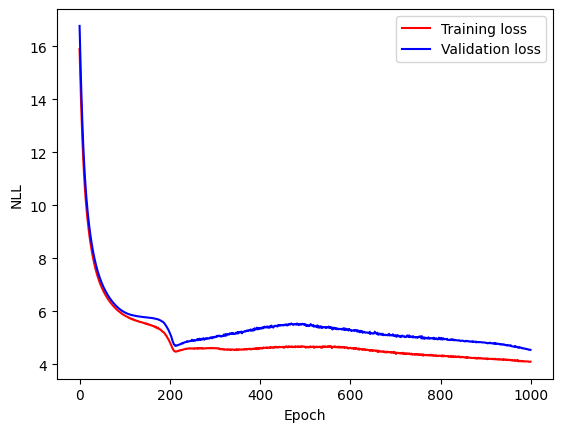

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

# Hyper-parameters
num_epochs = 1000

params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)
hidden_state = np.zeros((hidden_size, 1))
training_loss, validation_loss = [], []

for i in range(num_epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0

    validation_set.inputs, validation_set.targets = shuffle(validation_set.inputs, validation_set.targets, random_state=0)
    for inputs, targets in validation_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        hidden_state = np.zeros_like(hidden_state)
          
        # Forward pass
        # TWOJ KOD TUTAJ!   
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
        
        # Backward pass
        # TWOJ KOD TUTAJ!
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        epoch_validation_loss += loss

    training_set.inputs, training_set.targets = shuffle(training_set.inputs, training_set.targets, random_state=0)
    for inputs, targets in training_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # TWOJ KOD TUTAJ!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # TWOJ KOD TUTAJ!
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradient zanikł/eksplodował!')
        
        # Update parameters
        # TWOJ KOD TUTAJ!
        params = update_parameters(params, grads)
        
        epoch_training_loss += loss
        
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


inputs, targets = test_set[1]

inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Ciąg wejściowy:')
print(inputs)

print('\nCiąg wyjściowy:')
print(targets)

print('\nCiąg przewidziany:')
print([idx_to_word[np.argmax(output)] for output in outputs])

epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()
    

Poprawna implementacja powinna uzyskać stratę około **4** (przy sumie CE) po 1000 epok.

Teraz, gdy wyszkoliliśmy RNN, czas wystawić go na próbę. Dostarczymy sieci zdanie startowe i zobaczmy jak sobie poradzi!

In [11]:
def generate(params, sentence='', num_generate=10):
    sentence = sentence.split(' ')
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    hidden_state = np.zeros((hidden_size, 1))
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    output_sentence = sentence
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    for i in range(num_generate):
        output = outputs[-1]
        hidden_state = hidden_states[-1]
        output = output.reshape(1, output.shape[0], output.shape[1])
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        word = idx_to_word[np.argmax(outputs)]
        output_sentence.append(word)
        if word == 'EOS':
            break
    return output_sentence


test_examples = ['a a b', 'a a a a b', 'a a a a a a b', 'a', 'r n n']
for i, test_example in enumerate(test_examples):
    print(f'Przykład {i}:', test_example)
    print('Przewidziany ciąg:', generate(params, sentence=test_example), end='\n\n')

Przykład 0: a a b
Przewidziany ciąg: ['a', 'a', 'b', 'b', 'EOS']

Przykład 1: a a a a b
Przewidziany ciąg: ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'a']

Przykład 2: a a a a a a b
Przewidziany ciąg: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Przykład 3: a
Przewidziany ciąg: ['a', 'b', 'EOS']

Przykład 4: r n n
Przewidziany ciąg: ['r', 'n', 'n', 'EOS', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']



## Implementacja PyTorch

Zrobimy teraz taką samą sieć z wykorzystaniem PyTorcha

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # TWOJ KOD TUTAJ!
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=50)
        
        # Output layer
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        x, h = self.rnn(x)
        x = x.view(-1, self.rnn.hidden_size)
        x = self.l_out(x)
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (rnn): RNN(4, 50)
  (l_out): Linear(in_features=50, out_features=4, bias=False)
)


Epoch 0, training loss: 1.3476401006474215, validation loss: 1.3996705150604247
Epoch 10, training loss: 0.878337998600567, validation loss: 0.8547615885734559
Epoch 20, training loss: 0.738199242774178, validation loss: 0.6975960373878479
Epoch 30, training loss: 0.6740673533549496, validation loss: 0.631497243642807
Epoch 40, training loss: 0.6369565342571221, validation loss: 0.5978495681285858
Epoch 50, training loss: 0.6092798518491727, validation loss: 0.5744506108760834
Epoch 60, training loss: 0.5836138380508796, validation loss: 0.5537026679515838
Epoch 70, training loss: 0.5550701898687026, validation loss: 0.53152294754982
Epoch 80, training loss: 0.5170062480896127, validation loss: 0.5025566971302032
Epoch 90, training loss: 0.4691390678578732, validation loss: 0.4618585050106049
Epoch 100, training loss: 0.4335613161617634, validation loss: 0.42879931449890135
Epoch 110, training loss: 0.40637145213344517, validation loss: 0.39937095522880556
Epoch 120, training loss: 0.3

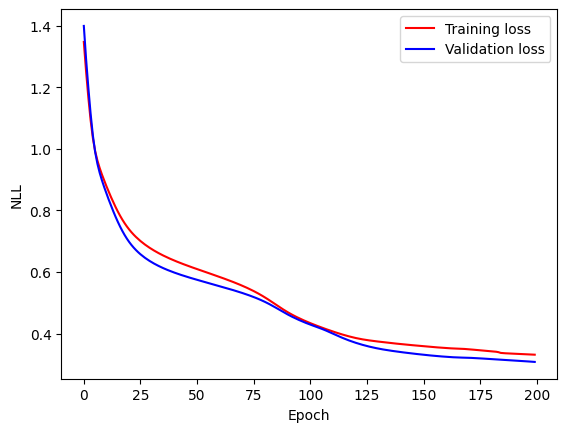

In [13]:
# Hyper-parameters
num_epochs = 200

net = MyRecurrentNet()

# Zdefiniuj funkcję straty i optymalizator dla tego problemu
# TWOJ KOD TUTAJ!
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

training_loss, validation_loss = [], []

for i in range(num_epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    for inputs, targets in validation_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # TWOJ KOD TUTAJ!
        outputs = net.forward(inputs_one_hot)
        
        # Compute loss
        # TWOJ KOD TUTAJ!
        loss = criterion(outputs, targets_idx)
        
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()

    for inputs, targets in training_set:
        
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # TWOJ KOD TUTAJ!
        outputs = net.forward(inputs_one_hot)
        
        # Compute loss
        # TWOJ KOD TUTAJ!
        loss = criterion(outputs, targets_idx)
        
        # Backward pass
        # TWOJ KOD TUTAJ!
        
        # zero grad
        optimizer.zero_grad()
        
        # backward
        loss.backward()
        
        # step...
        optimizer.step()

        epoch_training_loss += loss.detach().numpy()

    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
inputs, targets = test_set[1]

inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

targets_idx = torch.LongTensor(targets_idx)
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nCiąg wejściowy:')
print(inputs)

print('\nCiąg wyjściowy:')
print(targets)

print('\nCiąg przewidziany:')
print([idx_to_word[np.argmax(output)] for output in outputs])

epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

**Dodatkowo** zmień sieć RNN na LSTM i GRU zobacz czy osiągniesz lepsze wyniki. Sprawdź co najmniej trzy różne modele!

Training model MyRecurrentNetRNN
Epoch 0, training loss: 1.3639827943315692, validation loss: 1.430410294532776
Epoch 10, training loss: 0.8690494705064624, validation loss: 0.8525849199295044
Epoch 20, training loss: 0.7170336994470334, validation loss: 0.6797176861763
Epoch 30, training loss: 0.6612752919980124, validation loss: 0.6219861114025116
Epoch 40, training loss: 0.627256345222978, validation loss: 0.5909678077697754
Epoch 50, training loss: 0.5995568517668575, validation loss: 0.5673897886276245
Epoch 60, training loss: 0.572470071707286, validation loss: 0.5453398931026459
Epoch 70, training loss: 0.5428493971041605, validation loss: 0.5222603893280029
Epoch 80, training loss: 0.5057157767461795, validation loss: 0.4942918348312378
Epoch 90, training loss: 0.4581615781667186, validation loss: 0.45563413977622985
Epoch 100, training loss: 0.41863731762357786, validation loss: 0.41893596172332764
Epoch 110, training loss: 0.38688818964303706, validation loss: 0.3812102091312

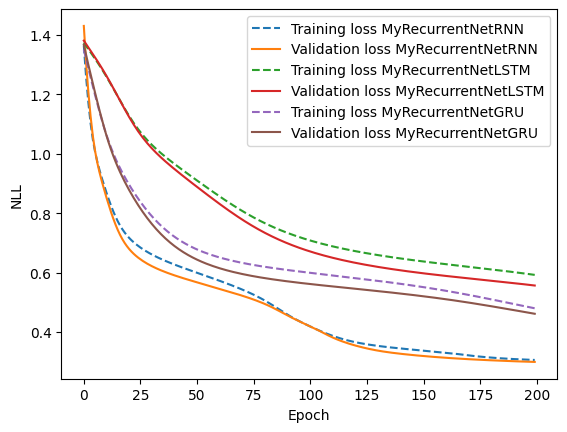

In [14]:
# TUTAJ KOD
class MyRecurrentNetRNN(nn.Module):
    def __init__(self):
        super(MyRecurrentNetRNN, self).__init__()
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=50)
        self.l_out = nn.Linear(in_features=50, out_features=vocab_size, bias=False)

    def forward(self, x):
        x, h = self.rnn(x)
        x = x.view(-1, self.rnn.hidden_size)
        x = self.l_out(x)
        return x


class MyRecurrentNetLSTM(nn.Module):
    def __init__(self):
        super(MyRecurrentNetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=50)
        self.l_out = nn.Linear(in_features=50, out_features=vocab_size, bias=False)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x.view(-1, self.lstm.hidden_size)
        x = self.l_out(x)
        return x


class MyRecurrentNetGRU(nn.Module):
    def __init__(self):
        super(MyRecurrentNetGRU, self).__init__()
        self.gru = nn.GRU(input_size=vocab_size, hidden_size=50)
        self.l_out = nn.Linear(in_features=50, out_features=vocab_size, bias=False)

    def forward(self, x):
        x, h = self.gru(x)
        x = x.view(-1, self.gru.hidden_size)
        x = self.l_out(x)
        return x

model_choices = [MyRecurrentNetRNN, MyRecurrentNetLSTM, MyRecurrentNetGRU]
training_loss_all, validation_loss_all = [], []

# Hyper-parameters
num_epochs = 200

for model_choice in model_choices:

    print(f'Training model {model_choice.__name__}')

    net = model_choice()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-3)

    training_loss, validation_loss = [], []

    for i in range(num_epochs):

        epoch_training_loss = 0
        epoch_validation_loss = 0

        net.eval()

        for inputs, targets in validation_set:
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)

            # Forward pass
            outputs = net.forward(inputs_one_hot)

            # Compute loss
            loss = criterion(outputs, targets_idx)

            epoch_validation_loss += loss.detach().numpy()

        net.train()

        for inputs, targets in training_set:

            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)

            # Forward pass
            outputs = net.forward(inputs_one_hot)

            # Compute loss
            loss = criterion(outputs, targets_idx)

            # Backward pass
            # zero grad
            optimizer.zero_grad()

            # backward
            loss.backward()

            # step...
            optimizer.step()

            epoch_training_loss += loss.detach().numpy()

        training_loss.append(epoch_training_loss / len(training_set))
        validation_loss.append(epoch_validation_loss / len(validation_set))

        if i % 10 == 0:
            print(
                f"Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}"
            )

    training_loss_all.append(training_loss)
    validation_loss_all.append(validation_loss)

epoch = np.arange(len(training_loss_all[0]))
plt.figure()

for i, model_choice in enumerate(model_choices):
    plt.plot(
        epoch,
        training_loss_all[i],
        label=f"Training loss {model_choice.__name__}",
        linestyle="--",
    )
    plt.plot(
        epoch,
        validation_loss_all[i],
        label=f"Validation loss {model_choice.__name__}",
        linestyle="-",
    )

plt.legend()
plt.xlabel("Epoch"), plt.ylabel("NLL")
plt.show()

# Zadanie 2 (10pt)

## **1.** Stworzenie sieci rekurencyjnej służącej do generowania tekstu

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import np_utils

Zaimportujemy wybrany plik kodowany jako UTF-8 w formacie txt, będący naszym materiałem do treningu sieci.
Pliki txt, które są w domenie publicznej lub posiadają licencje zezwalające na użytek można uzyskać ze stron:

*   [Projekt Gutenberg](https://www.gutenberg.org/browse/languages/pl)

*   [Wolne Lektury](https://wolnelektury.pl/)

*  [Portal Czytać](https://czytac.com/)

Wybrać po jednym tytule reprezentującym różne gatunki (proza, poezja, dramat).
Załadować wybrany plik reprezentujący prozę.

In [17]:
# Ładowanie pliku tekstowego ze znakami ASCII i konwersja do lowercase 
from keras.utils import get_file

URL = "https://wolnelektury.pl/media/book/txt/pies-baskervilleow.txt"
filename = get_file('pies-baskervilleow.txt', origin=URL)
text = open(filename, 'r', encoding='utf-8').read().lower()

print(text[:500])

255041/255041 [==============================] - 0s 1us/step
arthur conan doyle

pies baskerville'ów
dziwne przygody sherlocka holmesa
tłum. eugenia żmijewska

isbn 978-83-288-2223-8




i. pan sherlock holmes

pan sherlock holmes zwykł wstawać późno, o ile nie czuwał przez całą noc, a zdarzało mu się to nieraz. otóż owego dnia wstał wyjątkowo wcześnie. jadł śniadanie. stałem przy kominku. schyliłem się i podniosłem laskę, którą nasz gość zostawił wczorajszego wieczoru. był to kij gruby, z dużą gałką, utoczoną z drewna; pod gałką była srebrna obrączka, a 


In [18]:
text = text.replace("\n", " ")
split = int(0.9 * len(text))
train_text = text[:split]
test_text = text[split:]

Na początek tak jak już wiemy musimy wprowadzić odpowiednią reprezentacje danych. W tym celu dokonamy zamiany unikalnych znaków występujących w wybranej książce na postać liczbową.

In [19]:
# Tworzenie mapowania unikalnych znaków na postać liczbową 
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 63


In [20]:
max_length = 40
step = 3

def make_sequences(text, max_length=max_length, step=step):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_length, step):
        sequences.append(text[i: i + max_length])
        next_chars.append(text[i + max_length])
    return sequences, next_chars    

sequences, next_chars = make_sequences(train_text)
sequences_test, next_chars_test = make_sequences(test_text, step=10)

print('nb train sequences:', len(sequences))
print('nb test sequences:', len(sequences_test))

nb train sequences: 69472
nb test sequences: 2313


In [21]:
n_sequences = len(sequences)
n_sequences_test = len(sequences_test)
voc_size = len(chars)

# TWOJ KOD TUTAJ!
X = np.zeros((n_sequences, max_length, voc_size), dtype=np.float32)
y = np.zeros((n_sequences, voc_size), dtype=np.float32)

# TWOJ KOD TUTAJ!
X_test = np.zeros((n_sequences_test, max_length, voc_size), dtype=np.float32)
y_test = np.zeros((n_sequences_test, voc_size), dtype=np.float32)


for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
for i, sequence in enumerate(sequences_test):
    for t, char in enumerate(sequence):
        X_test[i, t, char_indices[char]] = 1
    y_test[i, char_indices[next_chars_test[i]]] = 1



In [35]:
# run garbage collector
import gc

gc.collect()

def perplexity(y_true, y_pred):
    likelihoods = np.sum(y_pred * y_true, axis=1)
    # TWOJ KOD TUTAJ!
    return np.exp(-np.mean(np.log(likelihoods)))
def model_perplexity(model, X, y, verbose=0):
    predictions = model.predict(X, verbose=verbose)
    gc.collect()
    return perplexity(y, predictions)

Zdefiniujmy prosty model sieci RNN wykorzystujący jedną warstwę LSTM i 256 komórek

In [45]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

Zdefiniujmy checkpoint, który może być przydatny w dalszych krokach,
warto do nazwy checkpointa dodać nazwę pliku, na bazie którego sieć jest
 uczona

In [39]:
filepath="basic-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Przeprowadź trening z wykorzystaniem `batch_size=128` oraz z wykorzystaniem zdefiniowanego powyżej callback'a przez min. 20 epok. Wykorzystaj funkcję categorical 
crossentropy, optimizer ADAM oraz wyświetlaj perplexity na zbiorze 
testowym do oceny modelu w każdej epoce.

In [46]:
# TWOJ KOD TUTAJ!
from keras.callbacks import Callback

class PerplexityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Perplexity: {model_perplexity(model, X_test, y_test)}')

callbacks_list = [checkpoint, PerplexityCallback()]

model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
543/543 [==============================] - ETA: 0s - loss: 2.9259
Epoch 1: loss did not improve from 0.58622
Perplexity: 13.201790809631348
543/543 [==============================] - 11s 16ms/step - loss: 2.9259
Epoch 2/20
541/543 [============================>.] - ETA: 0s - loss: 2.4372
Epoch 2: loss did not improve from 0.58622
Perplexity: 11.39409351348877
543/543 [==============================] - 8s 15ms/step - loss: 2.4369
Epoch 3/20
543/543 [==============================] - ETA: 0s - loss: 2.2990
Epoch 3: loss did not improve from 0.58622
Perplexity: 10.257583618164062
543/543 [==============================] - 8s 14ms/step - loss: 2.2990
Epoch 4/20
542/543 [============================>.] - ETA: 0s - loss: 2.1937
Epoch 4: loss did not improve from 0.58622
Perplexity: 9.454593658447266
543/543 [==============================] - 8s 15ms/step - loss: 2.1937
Epoch 5/20
541/543 [============================>.] - ETA: 0s - loss: 2.1029
Epoch 5: loss did not improve from 0

In [48]:
# Wybierzmy losowe ziarno będące początkiem generowanej sekwencji
import sys
start = np.random.randint(0, len(sequences)-1)
seed_string = sequences[start]
print("Seed:")
print("\"", seed_string, "\"")

generated = seed_string
prefix = seed_string
length = 200

print("Generated:")
print(seed_string, end="")
for i in range(length):
    x = np.zeros((1, max_length, voc_size))
    shift = max_length - len(prefix)
    for t, char in enumerate(prefix):
        x[0, t + shift, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]
    sys.stdout.write(next_char)
    generated += next_char
    prefix = prefix[1:] + next_char

print("\nKoniec")

Seed:
" iadał. zaczynałem przypuszczać, że to on "
Generated:
iadał. zaczynałem przypuszczać, że to on więczył się tej przyjaciel wielkiego postrzeż nie wyjaśniesi — spotonne wyczyła z sir henryka, a był to miej sir henryka, a barrymore wycała nie wyprzedziłem ten listy, a zaprawa zajemniczajem o sir 
Koniec


**Dodatkowo** wybierz inne modele sieci wykorzystując inne warstwy, dropout lub kilka warstw np. GRU. Przetestuj przynajmniej trzy różne sieci!

In [50]:
# TWOJ KOD TUTAJ!
# model 1: wielowarstwowy LSTM z dropoutem
gc.collect()

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam")

model.fit(X, y, epochs=30, batch_size=128)

# perpelxity
print(f"Perplexity: {model_perplexity(model, X_test, y_test)}")

start = np.random.randint(0, len(sequences) - 1)
seed_string = sequences[start]
print("Seed:")
print('"', seed_string, '"')

generated = seed_string
prefix = seed_string
length = 200

print("Generated:")
print(seed_string, end="")
for i in range(length):
    x = np.zeros((1, max_length, voc_size))
    shift = max_length - len(prefix)
    for t, char in enumerate(prefix):
        x[0, t + shift, char_indices[char]] = 1.0

    preds = model.predict(x, verbose=0)
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]
    sys.stdout.write(next_char)
    generated += next_char
    prefix = prefix[1:] + next_char

print("\nKoniec")

Epoch 1/30
543/543 [==============================] - 20s 29ms/step - loss: 3.0982
Epoch 2/30
543/543 [==============================] - 16s 29ms/step - loss: 2.5130
Epoch 3/30
543/543 [==============================] - 15s 28ms/step - loss: 2.2741
Epoch 4/30
543/543 [==============================] - 15s 28ms/step - loss: 2.0989
Epoch 5/30
543/543 [==============================] - 16s 29ms/step - loss: 1.9647
Epoch 6/30
543/543 [==============================] - 15s 28ms/step - loss: 1.8533
Epoch 7/30
543/543 [==============================] - 16s 29ms/step - loss: 1.7612
Epoch 8/30
543/543 [==============================] - 16s 30ms/step - loss: 1.6833
Epoch 9/30
543/543 [==============================] - 16s 30ms/step - loss: 1.6153
Epoch 10/30
543/543 [==============================] - 16s 30ms/step - loss: 1.5492
Epoch 11/30
543/543 [==============================] - 16s 30ms/step - loss: 1.4950
Epoch 12/30
543/543 [==============================] - 17s 31ms/step - loss: 1.4406
E

In [51]:
# model 2: wielowarstwowy GRU z dropoutem
from keras.layers import GRU

gc.collect()

model = Sequential()
model.add(GRU(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam")

model.fit(X, y, epochs=30, batch_size=128)

# perpelxity
print(f"Perplexity: {model_perplexity(model, X_test, y_test)}")

start = np.random.randint(0, len(sequences) - 1)
seed_string = sequences[start]
print("Seed:")
print('"', seed_string, '"')

generated = seed_string
prefix = seed_string
length = 200

print("Generated:")
print(seed_string, end="")
for i in range(length):
    x = np.zeros((1, max_length, voc_size))
    shift = max_length - len(prefix)
    for t, char in enumerate(prefix):
        x[0, t + shift, char_indices[char]] = 1.0

    preds = model.predict(x, verbose=0)
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]
    sys.stdout.write(next_char)
    generated += next_char
    prefix = prefix[1:] + next_char

print("\nKoniec")

Epoch 1/30
543/543 [==============================] - 17s 25ms/step - loss: 2.6425
Epoch 2/30
543/543 [==============================] - 14s 25ms/step - loss: 2.1924
Epoch 3/30
543/543 [==============================] - 13s 24ms/step - loss: 2.0050
Epoch 4/30
543/543 [==============================] - 13s 24ms/step - loss: 1.8605
Epoch 5/30
543/543 [==============================] - 16s 30ms/step - loss: 1.7463
Epoch 6/30
543/543 [==============================] - 14s 26ms/step - loss: 1.6569
Epoch 7/30
543/543 [==============================] - 14s 25ms/step - loss: 1.5818
Epoch 8/30
543/543 [==============================] - 14s 26ms/step - loss: 1.5171
Epoch 9/30
543/543 [==============================] - 15s 27ms/step - loss: 1.4634
Epoch 10/30
543/543 [==============================] - 15s 28ms/step - loss: 1.4074
Epoch 11/30
543/543 [==============================] - 15s 28ms/step - loss: 1.3597
Epoch 12/30
543/543 [==============================] - 15s 28ms/step - loss: 1.3153
E

In [52]:
# model 3: mieszany LSTM z GRU z dropoutem
gc.collect()

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dense(y.shape[1], activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam")

model.fit(X, y, epochs=30, batch_size=128)

# perpelxity
print(f"Perplexity: {model_perplexity(model, X_test, y_test)}")

start = np.random.randint(0, len(sequences) - 1)
seed_string = sequences[start]
print("Seed:")
print('"', seed_string, '"')

generated = seed_string
prefix = seed_string
length = 200

print("Generated:")
print(seed_string, end="")
for i in range(length):
    x = np.zeros((1, max_length, voc_size))
    shift = max_length - len(prefix)
    for t, char in enumerate(prefix):
        x[0, t + shift, char_indices[char]] = 1.0

    preds = model.predict(x, verbose=0)
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]
    sys.stdout.write(next_char)
    generated += next_char
    prefix = prefix[1:] + next_char

print("\nKoniec")

Epoch 1/30
543/543 [==============================] - 26s 37ms/step - loss: 3.1221
Epoch 2/30
543/543 [==============================] - 20s 38ms/step - loss: 2.5679
Epoch 3/30
543/543 [==============================] - 21s 38ms/step - loss: 2.3687
Epoch 4/30
543/543 [==============================] - 21s 38ms/step - loss: 2.1804
Epoch 5/30
543/543 [==============================] - 22s 40ms/step - loss: 2.0245
Epoch 6/30
543/543 [==============================] - 21s 39ms/step - loss: 1.9079
Epoch 7/30
543/543 [==============================] - 22s 40ms/step - loss: 1.8113
Epoch 8/30
543/543 [==============================] - 22s 40ms/step - loss: 1.7298
Epoch 9/30
543/543 [==============================] - 22s 40ms/step - loss: 1.6674
Epoch 10/30
543/543 [==============================] - 22s 41ms/step - loss: 1.6081
Epoch 11/30
543/543 [==============================] - 22s 40ms/step - loss: 1.5578
Epoch 12/30
543/543 [==============================] - 22s 41ms/step - loss: 1.5173
E